In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from rocketpy import Function, LiquidMotor, MassFlowRateBasedTank, UllageBasedTank, MassBasedTank, Fluid

In [5]:
%matplotlib widget

# Input Curves

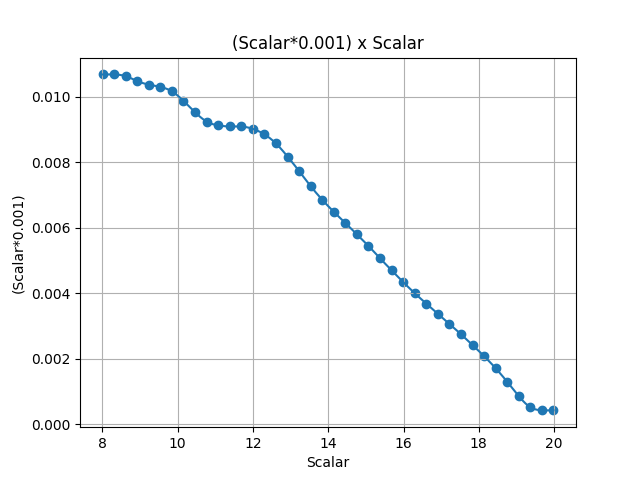

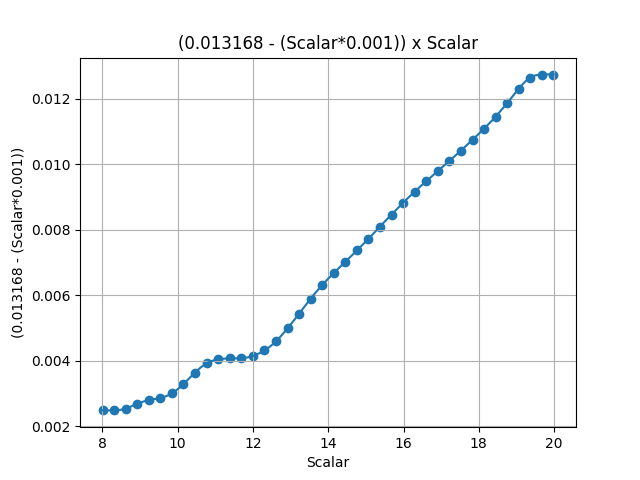

In [6]:
LOX_Volume_Liters = Function("../../data/SEBLM/test124_Lox_Volume.csv")
LOX_Volume = LOX_Volume_Liters * 0.001
LOX_Volume.setDiscrete(8.003, 19.984, 40)
LOX_Volume.plot(forceData=True)
LOX_tank_ullage = 0.013168 - LOX_Volume
LOX_tank_ullage.plot(forceData=True)

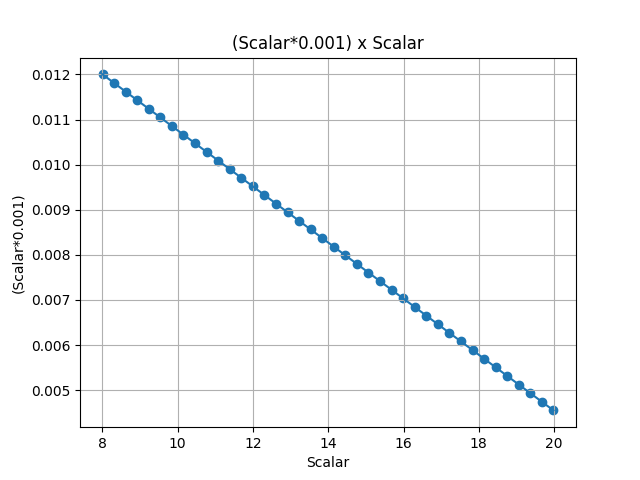

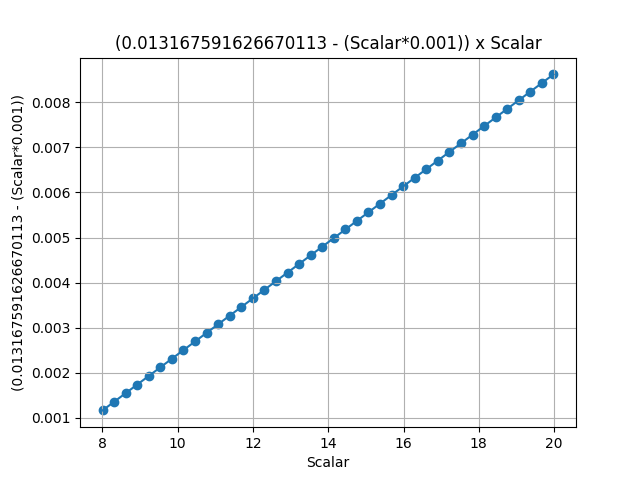

In [7]:
Propane_Volume_Liters = Function("../../data/SEBLM/test124_Propane_Volume.csv")
Propane_Volume = Propane_Volume_Liters * 0.001 # m3
Propane_Volume.setDiscrete(8.003, 19.984, 40)
Propane_Volume.plot(forceData=True)
Propane_tank_ullage = 0.013167591626670113 - Propane_Volume
Propane_tank_ullage.plot(forceData=True)

# Fluids

In [8]:
LOX = Fluid("LOX", 1024, 1)
Propane = Fluid("Propane", 566, 1)
LOXTankPressurizingGas = Fluid("N2", 31.3/28, 1) # 450 PSI
PropaneTankPressurizingGas = Fluid("N2", 313*300/4500/28, 1) # 300 PSI
PressurizingGas = Fluid("N2", 313/28, 1)# 4500 PSI

# LOX Tank

In [9]:
LOX_tank = UllageBasedTank(
    name="LOX Tank",
    diameter=2*0.0744,
    height=0.658,
    gas=LOXTankPressurizingGas,
    liquid=LOX,
    ullage=LOX_tank_ullage,
    bottomCap="spherical",
    upperCap="spherical"
)

In [10]:
LOX_tank.volume * LOXTankPressurizingGas.density

0.01471948635409909

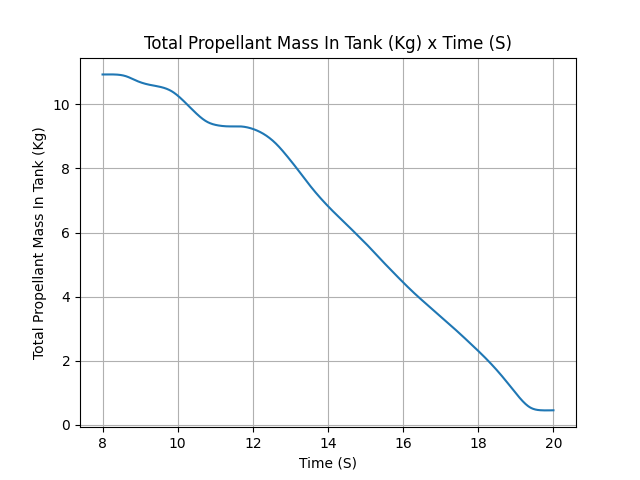

In [108]:
LOX_tank.mass.plot(8, 20)

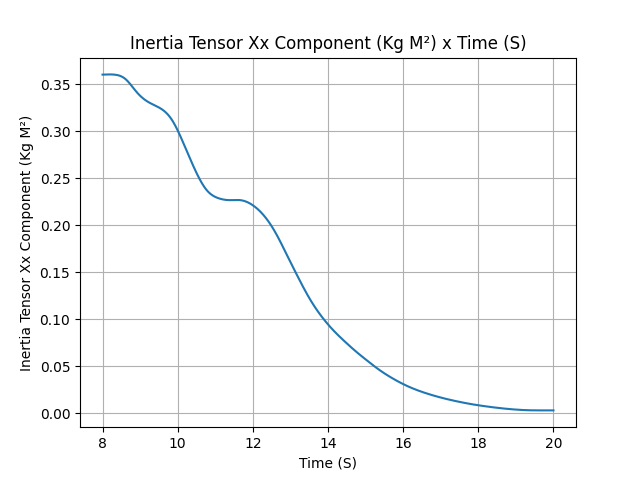

In [109]:
LOX_tank.inertiaXX.plot(8, 20)

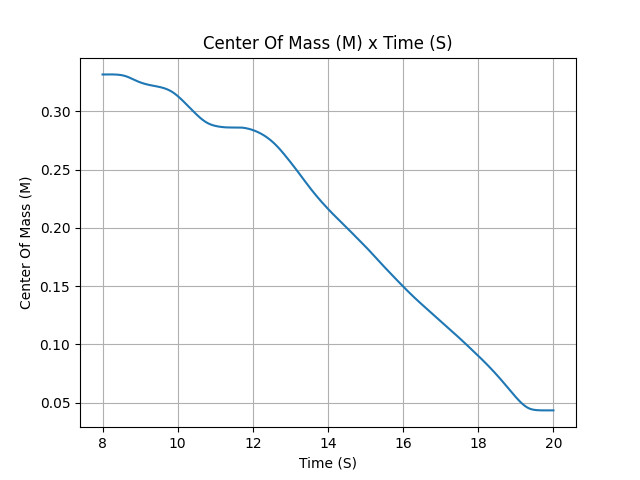

In [110]:
LOX_tank.centerOfMass.plot(8, 20)

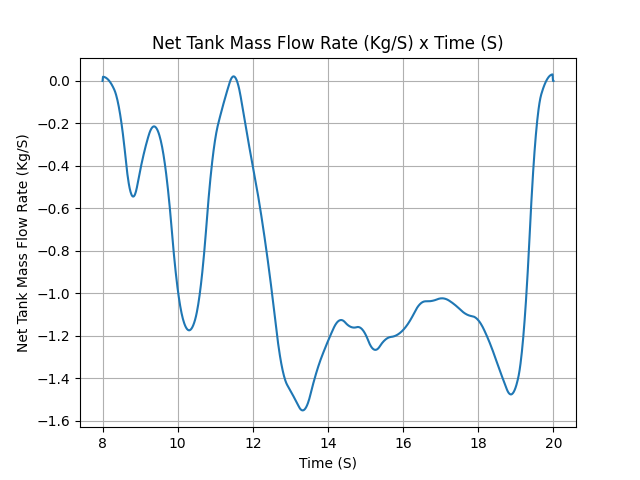

In [111]:
LOX_tank.netMassFlowRate.plot(8, 20, forceData=True)

# Propane Tank

In [11]:
Propane_tank = UllageBasedTank(
    name="Propane Tank",
    diameter=2*0.0744,
    height=0.658,
    gas=PropaneTankPressurizingGas,
    liquid=Propane,
    ullage=Propane_tank_ullage,
    bottomCap="spherical",
    upperCap="spherical"
)

In [12]:
Propane_tank.volume * PropaneTankPressurizingGas.density

0.009812990902732728

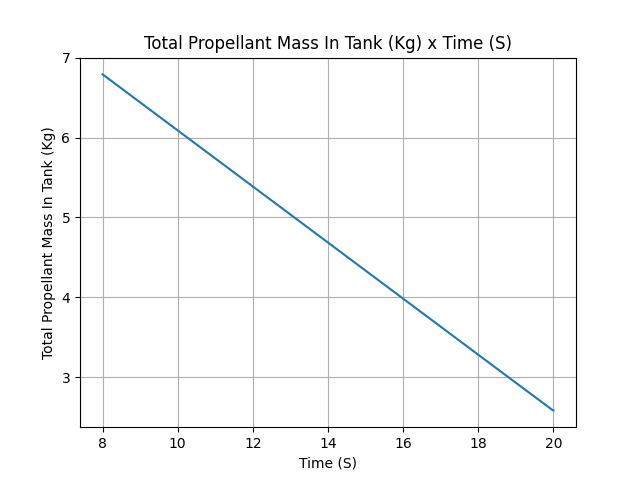

In [13]:
Propane_tank.mass.plot(8, 20)

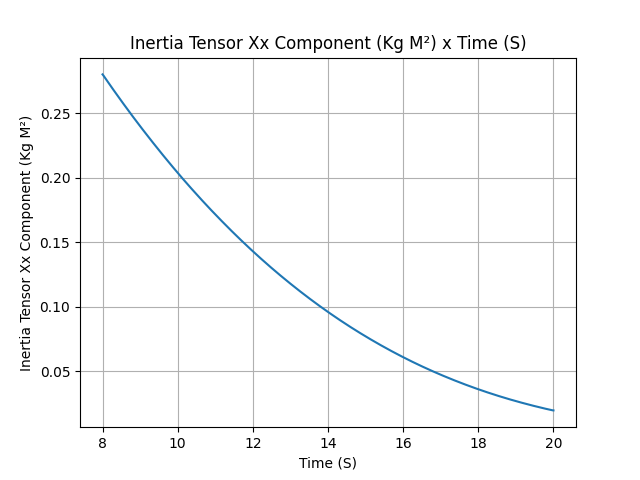

In [115]:
Propane_tank.inertiaXX.plot(8, 20)

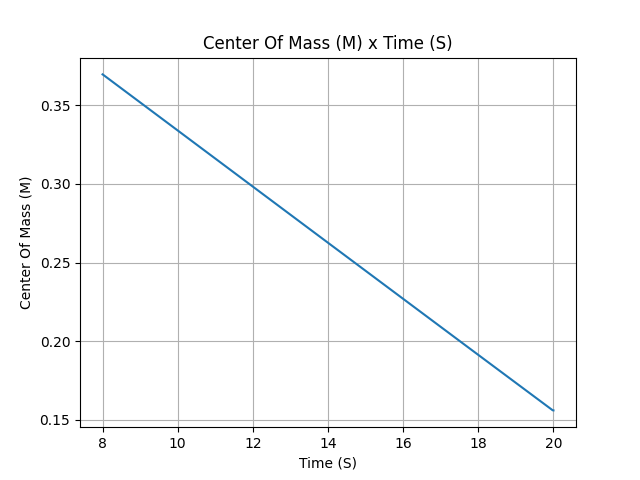

In [116]:
Propane_tank.centerOfMass.plot(8, 20)

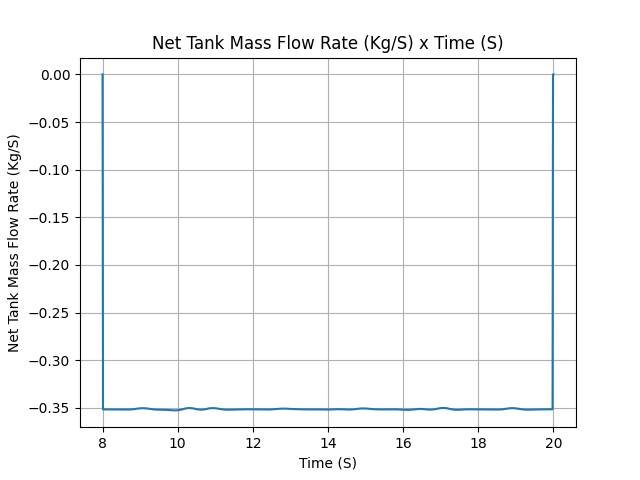

In [117]:
Propane_tank.netMassFlowRate.plot(8, 20, forceData=True)

# Pressure Tank

In [14]:
Pressure_tank = MassBasedTank(
    name="Pressure Tank",
    diameter=0.135,
    height=0.846,
    liquid_mass=0,
    gas_mass="../../data/SEBLM/pressurantMassFiltered.csv",
    gas=PressurizingGas,
    liquid=PressurizingGas,
    bottomCap="spherical",
    upperCap="spherical",
)

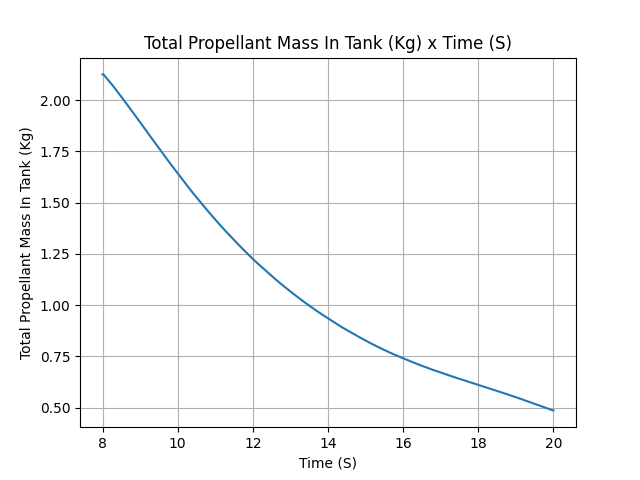

In [119]:
Pressure_tank.mass.plot(8, 20)

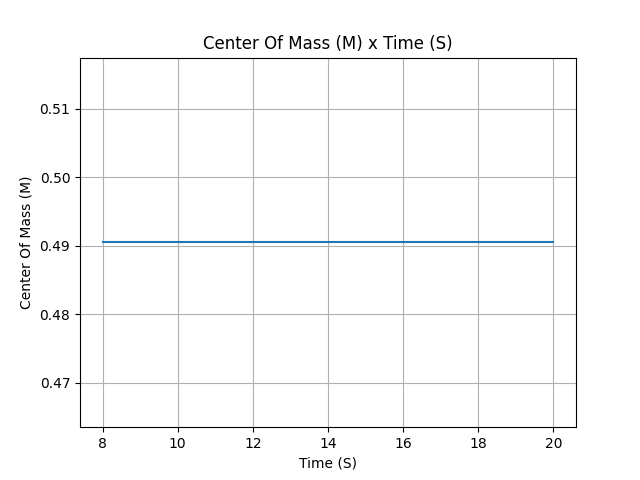

In [15]:
Pressure_tank.centerOfMass.plot(8, 20)

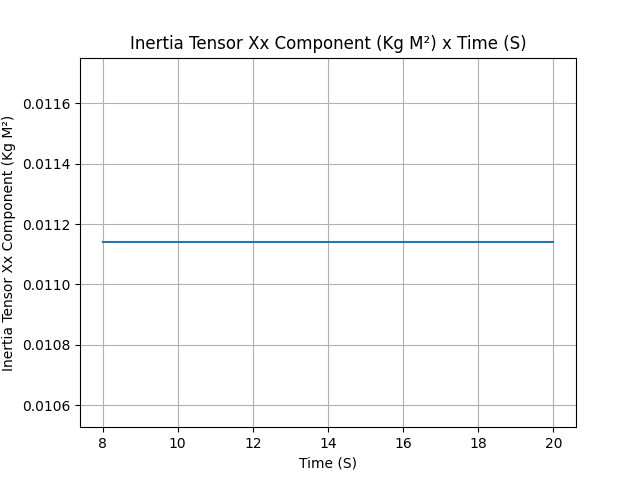

In [121]:
Pressure_tank.inertiaXX.plot(8, 20)

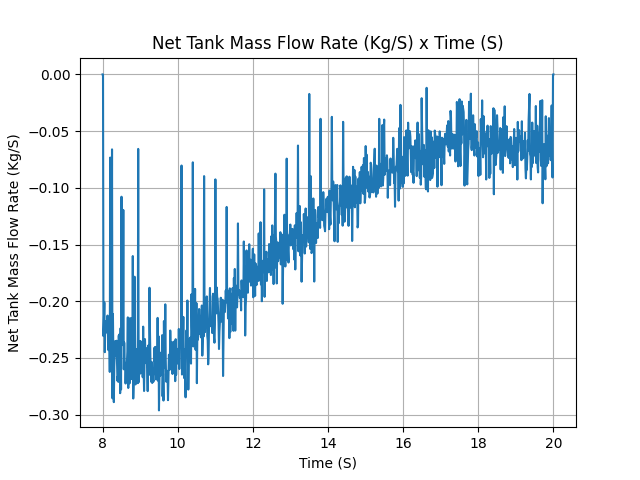

In [16]:
Pressure_tank.netMassFlowRate.plot(8, 20)

# Liquid Motor

In [17]:
SEBLM = LiquidMotor(
    thrustSource="../../data/SEBLM/test124_Thrust_Curve.csv",
    burnOut=20.0,
    nozzleRadius=0.069/2,
    nozzlePosition=-1.364,
    throatRadius=0.03/2,
    coordinateSystemOrientation="nozzleToCombustionChamber",
)

SEBLM.addTank(Propane_tank, position=-1.048)
SEBLM.addTank(LOX_tank, position=0.711)
SEBLM.addTank(Pressure_tank, position=2.007)

In [18]:
SEBLM.mass.setDiscrete(8, 20, 50)
SEBLM.massDot.setDiscrete(8, 20, 50)
SEBLM.centerOfMass.setDiscrete(8, 20, 50)
SEBLM.Ixx.setDiscrete(8, 20, 50)
SEBLM.Iyy.setDiscrete(8, 20, 50)

Function from R1 to R1 : (x) → (Scalar)

20.0
1
-1.364


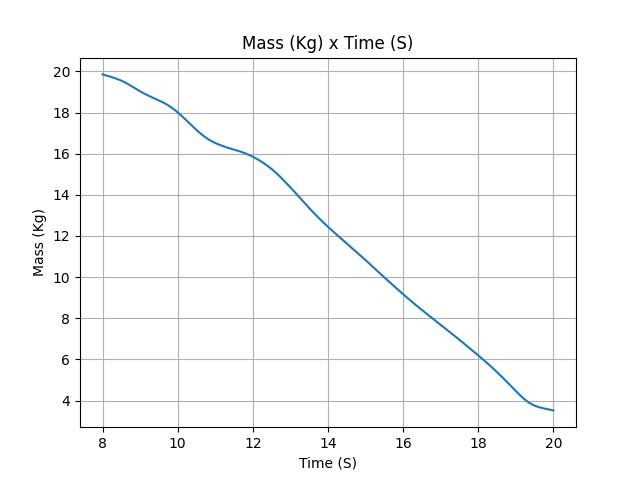

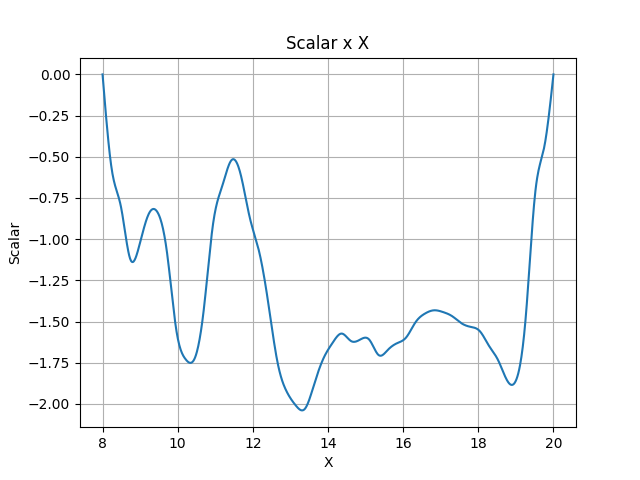

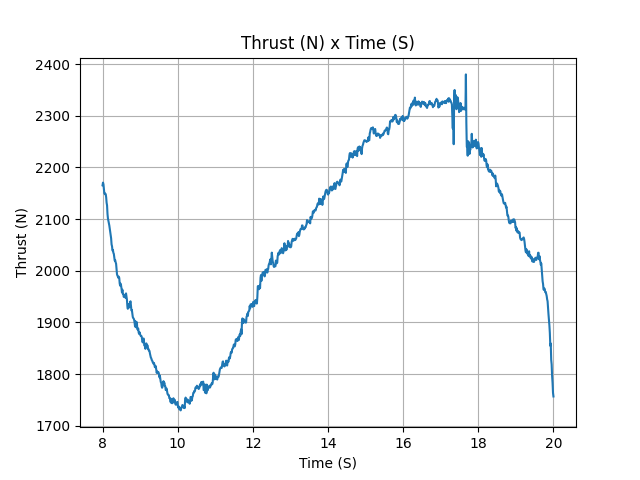

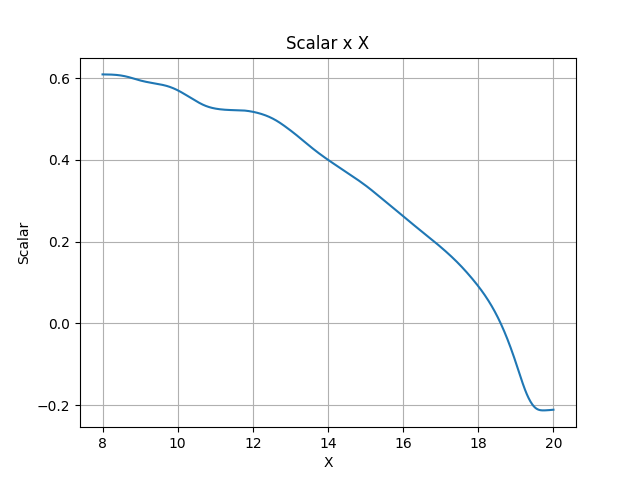

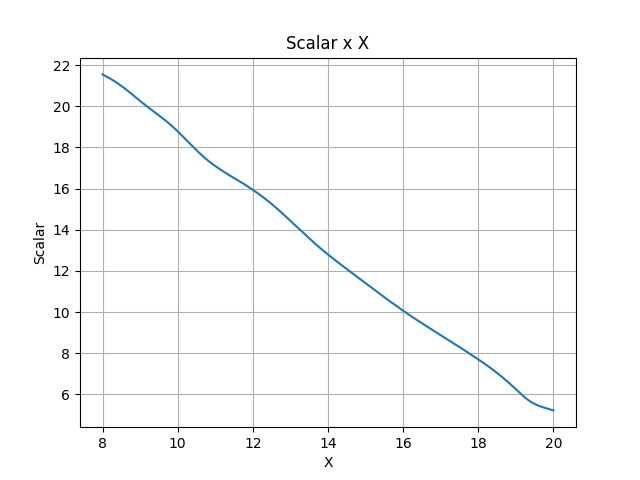

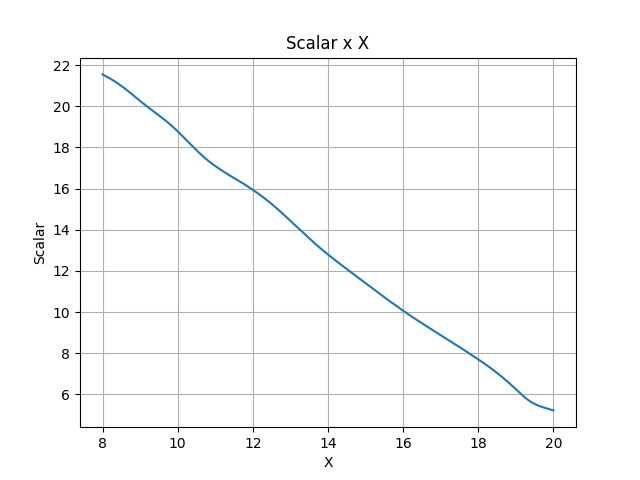

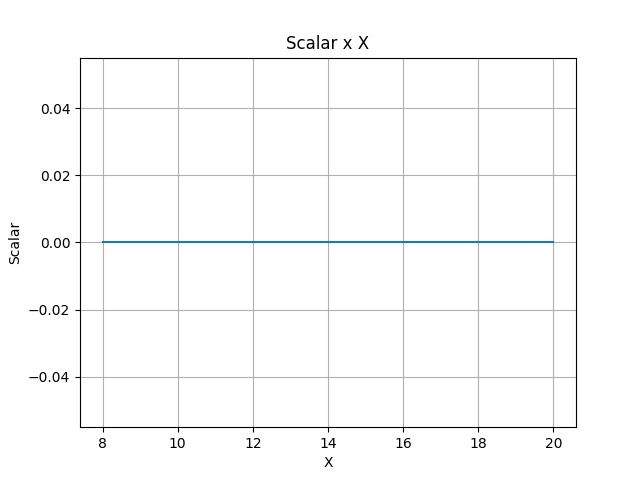

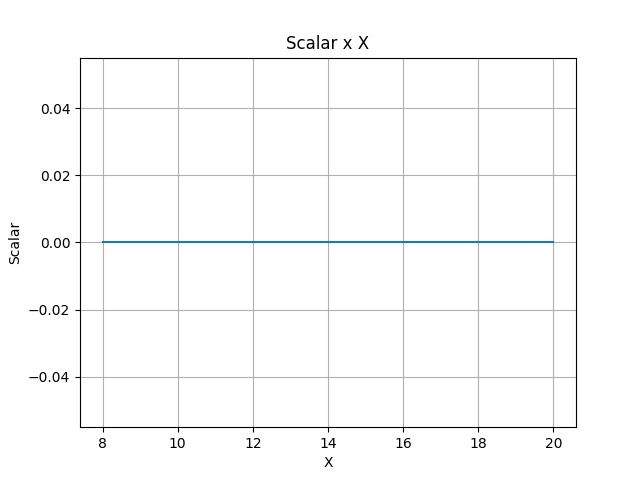

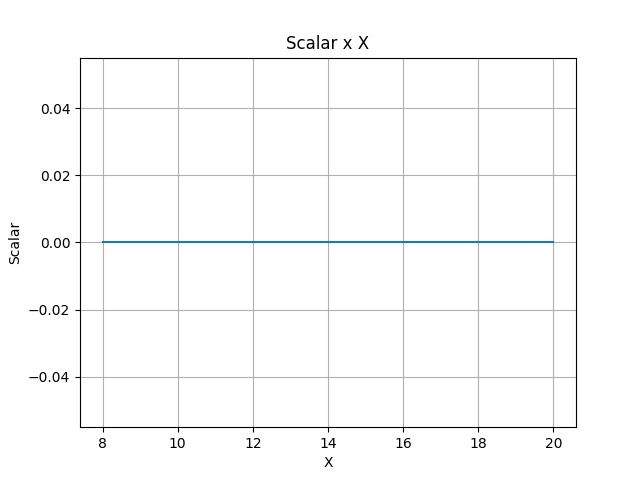

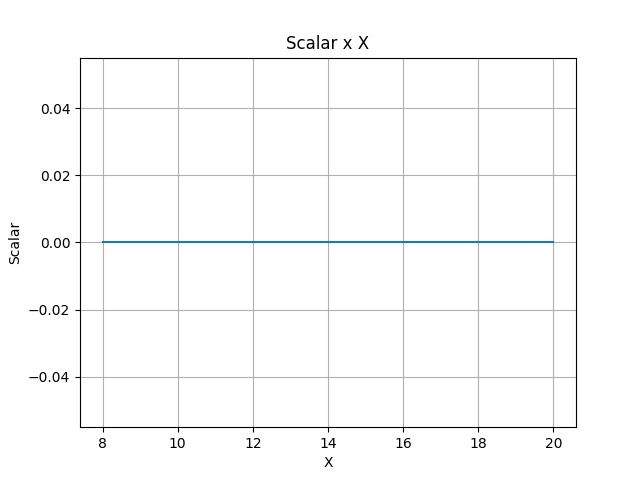

In [19]:
print(SEBLM.burnOutTime)
print(SEBLM._csys)
print(SEBLM.nozzlePosition)
SEBLM.mass.plot(8, 20)
SEBLM.massDot.plot(8, 20)
SEBLM.thrust.plot(8, 20)
SEBLM.centerOfMass.plot(8, 20)
SEBLM.Ixx.plot(8, 20)
SEBLM.Iyy.plot(8, 20)
SEBLM.Izz.plot(8, 20)
SEBLM.Ixy.plot(8, 20)
SEBLM.Ixz.plot(8, 20)
SEBLM.Iyz.plot(8, 20)

In [126]:
12*2000

24000

In [20]:
Propane_tank.liquidMass(20)

2.5753

In [21]:
Propane_tank.gasMass(20)

0.0064221575693993935

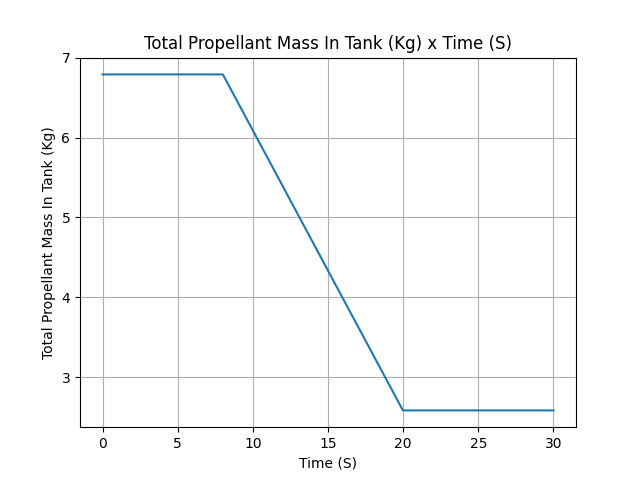

In [22]:
Propane_tank.mass.plot(0, 30)

# Rocket Definition

In [23]:
from rocketpy import Rocket

SEBRocket = Rocket(
    radius=0.098,
    mass=63.4,
    inertiaI=25,
    inertiaZ=1,
    powerOffDrag="../../data/SEBLM/drag.csv",
    powerOnDrag="../../data/SEBLM/drag.csv",
    centerOfDryMassPosition=3.23,
    coordinateSystemOrientation="noseToTail",
)
SEBRocket.addMotor(SEBLM, position=5.75)
SEBRocket.addNose(length=0.7, kind="vonKarman", position=0)
SEBRocket.addTail(
    topRadius=0.098, bottomRadius=0.058, length=0.198, position=5.69-0.198
)

SEBRocket.addTrapezoidalFins(
    n=3,
    rootChord=0.355,
    tipChord=0.0803,
    span=0.156,
    position=5.25,
    cantAngle=0,
)

# Ignore next line
SEBRocket.setRailButtons([-1, 1])


Inertia Details
Rocket Dry Mass: 63.4 kg (No Propellant)
Rocket Total Mass: 83.25200404245578 kg (With Propellant)

Geometrical Parameters
Rocket Radius: 0.098 m

Aerodynamics Stability
Initial Static Margin: 0.198 c
Final Static Margin: 0.495 c

Aerodynamics Plots


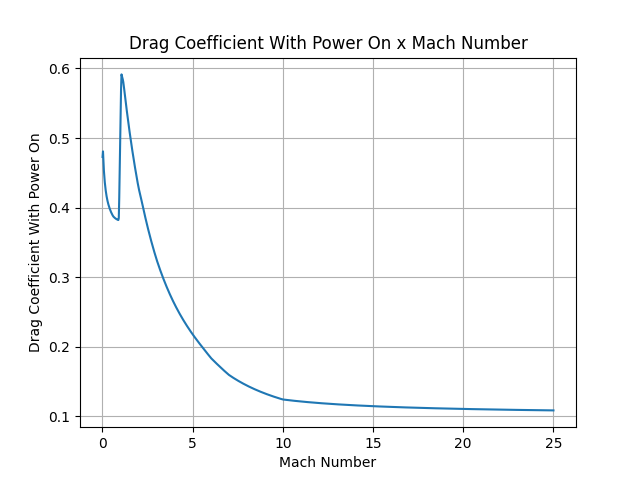

In [24]:
SEBRocket.info()

In [25]:
from rocketpy import Environment

env = Environment(
    railLength=18.28, latitude=35.347122986338356, longitude=-117.80893423073582
)

# env.setDate((2022,12,3,14+7,0,0)) # UTC
# env.setAtmosphericModel(type="Forecast", file="GFS")

In [26]:
from rocketpy import Flight

TestFlight = Flight(rocket=SEBRocket, environment=env, inclination=90, heading=23, maxTimeStep=0.1)

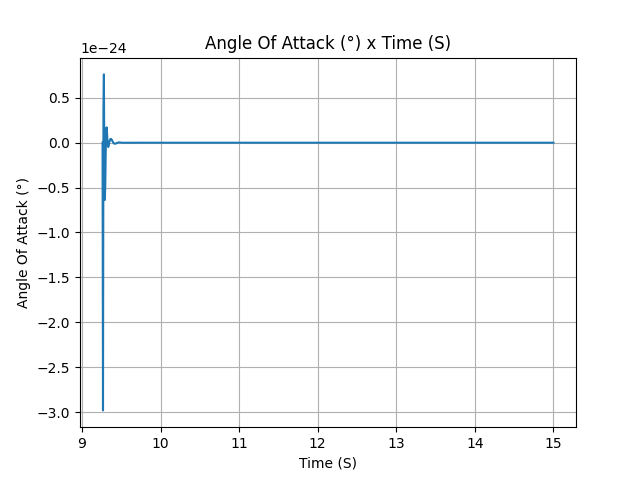

In [27]:
TestFlight.angleOfAttack.plot(TestFlight.outOfRailTime, 15)

Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 0.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.980 | e1: 0.000 | e2: -0.000 | e3: -0.199
Euler Angles - Spin φ : -191.50° | Nutation θ: -0.00° | Precession ψ: 168.50°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Launch Rail Orientation

Launch Rail Inclination: 90.00°
Launch Rail Heading: 23.00°


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


 Rail Departure State

Rail Departure Time: 9.262 s
Rail Departure Velocity: 17.551 m/s
Rail Departure Static Margin: 0.202 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 2.283
Rail Departure Reynolds Number: 3.440e+00


BurnOut State

BurnOut time: 20.000 s
Altitude at burnOut: 1096.277 m (AGL)
Rocket velocity at burnOut: 198.974 m/s
Freestream velocity at burnOut: 198.974 m/s
Mach Number at burnOut: 0.593
Kinetic energy at burnOut: 1.325e+06 J


Apoge

c:\users\giovaniceotto\repositories\rocketpy\rocketpy\Flight.py:3131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1 = plt.figure(figsize=(9, 9))
c:\users\giovaniceotto\repositories\rocketpy\rocketpy\Flight.py:3157: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax1.set_ylim3d([minXY, maxXY])
c:\users\giovaniceotto\repositories\rocketpy\rocketpy\Flight.py:3158: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax1.set_xlim3d([minXY, maxXY])


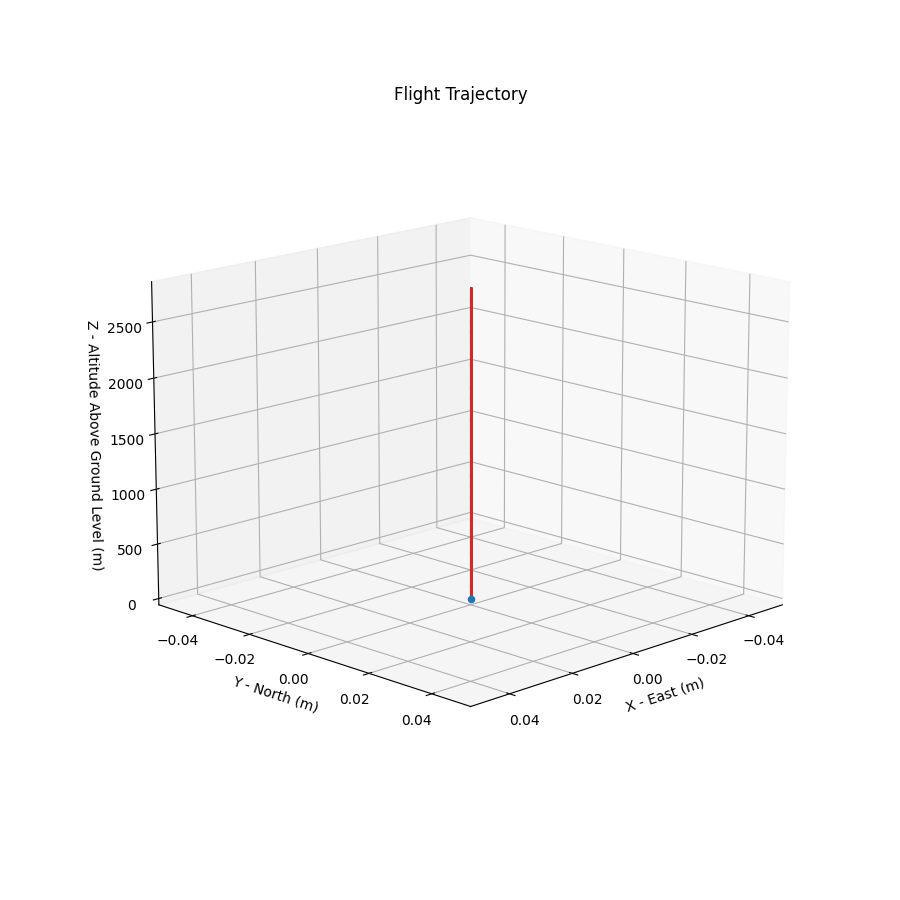



Trajectory Kinematic Plots



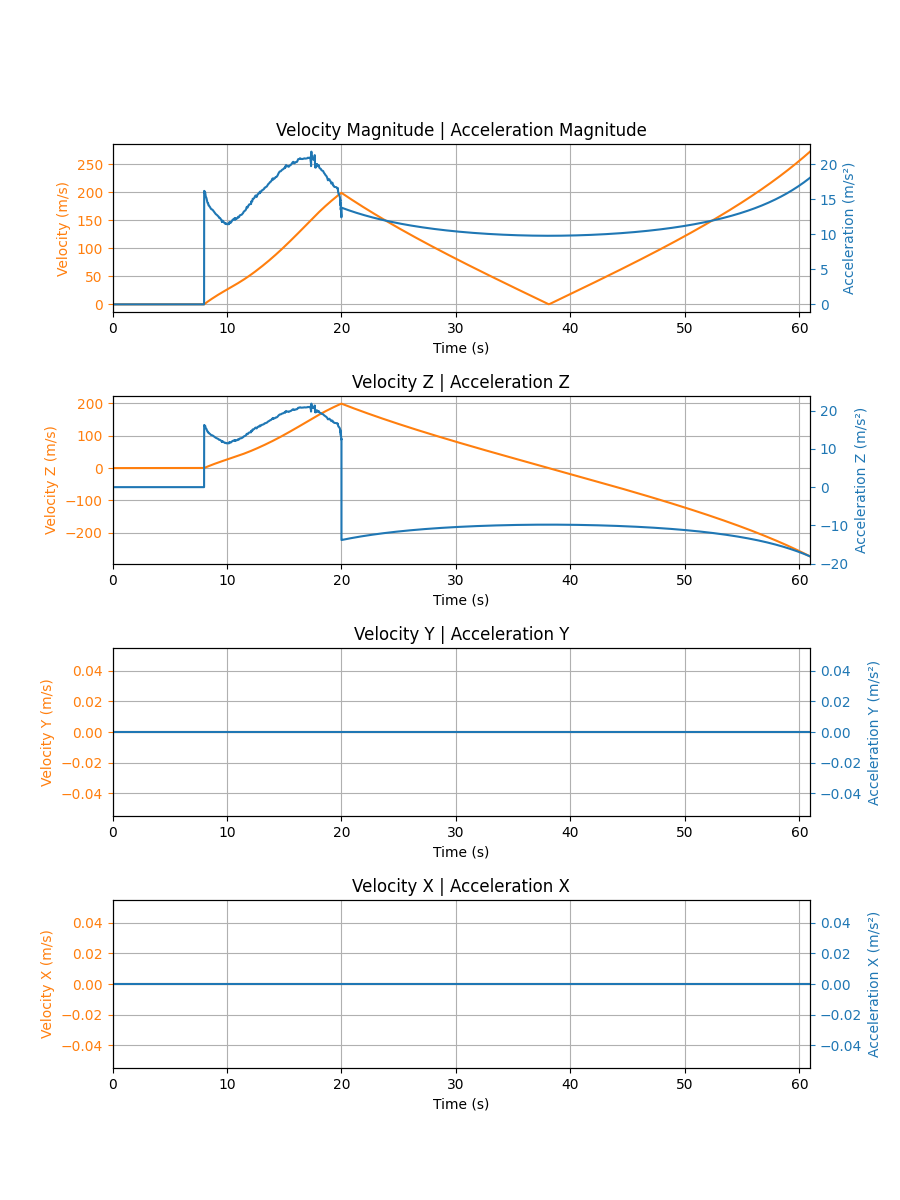



Angular Position Plots



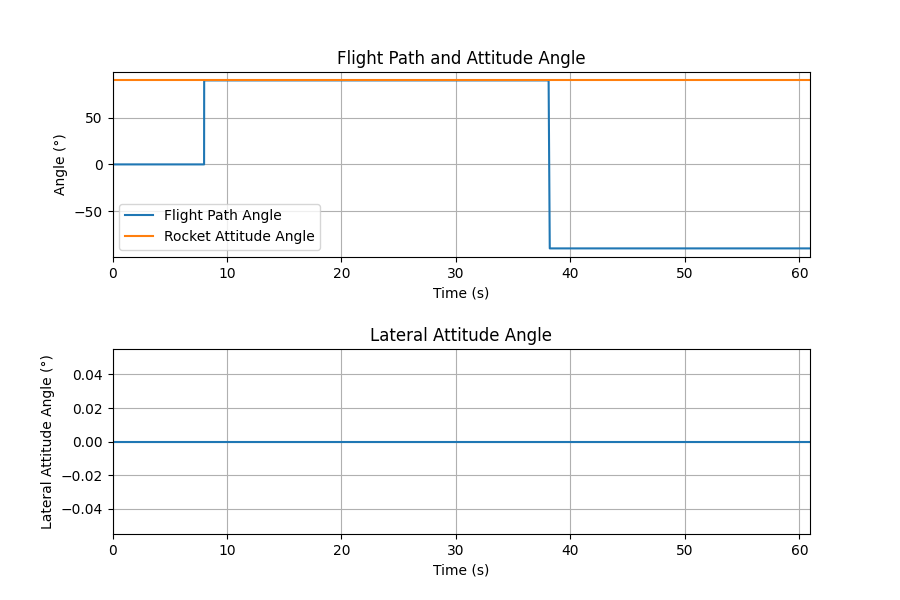



Path, Attitude and Lateral Attitude Angle plots



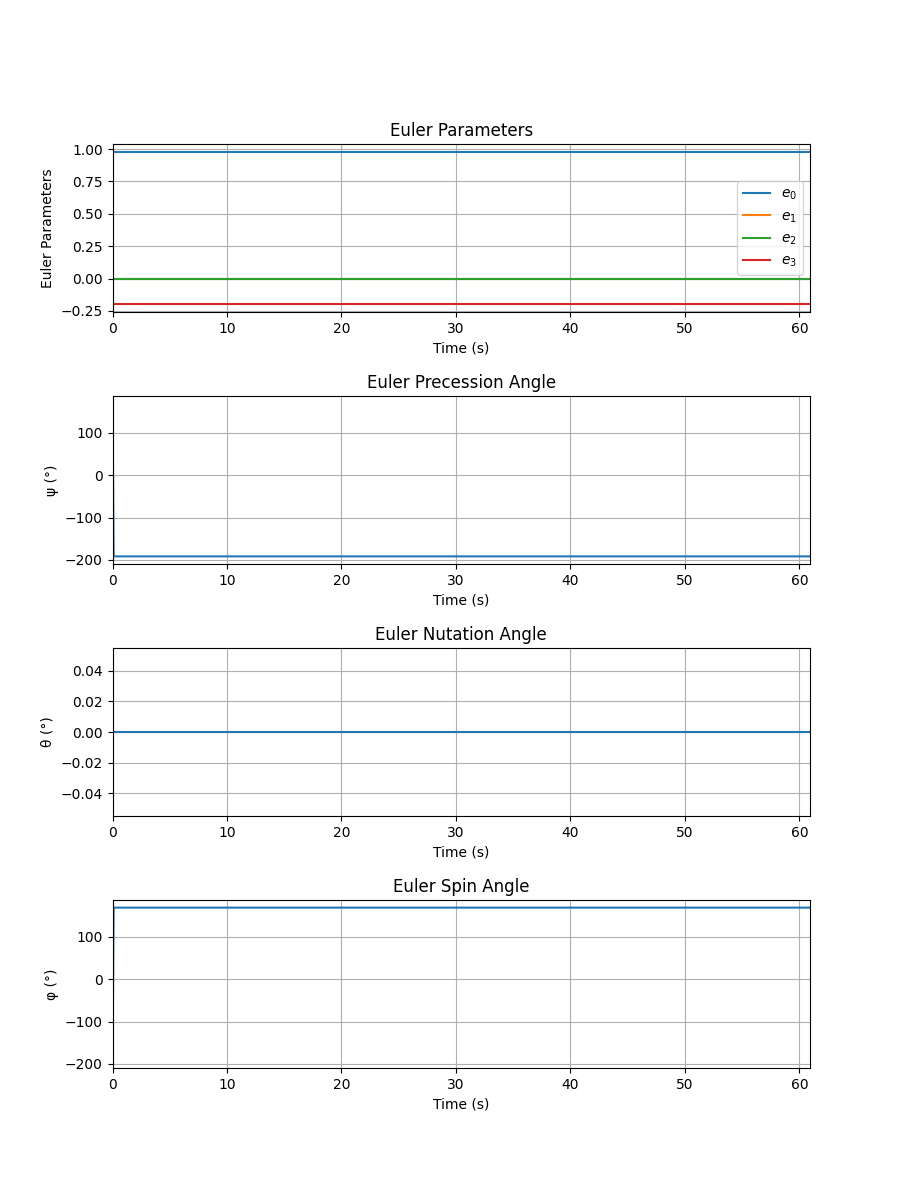



Trajectory Angular Velocity and Acceleration Plots



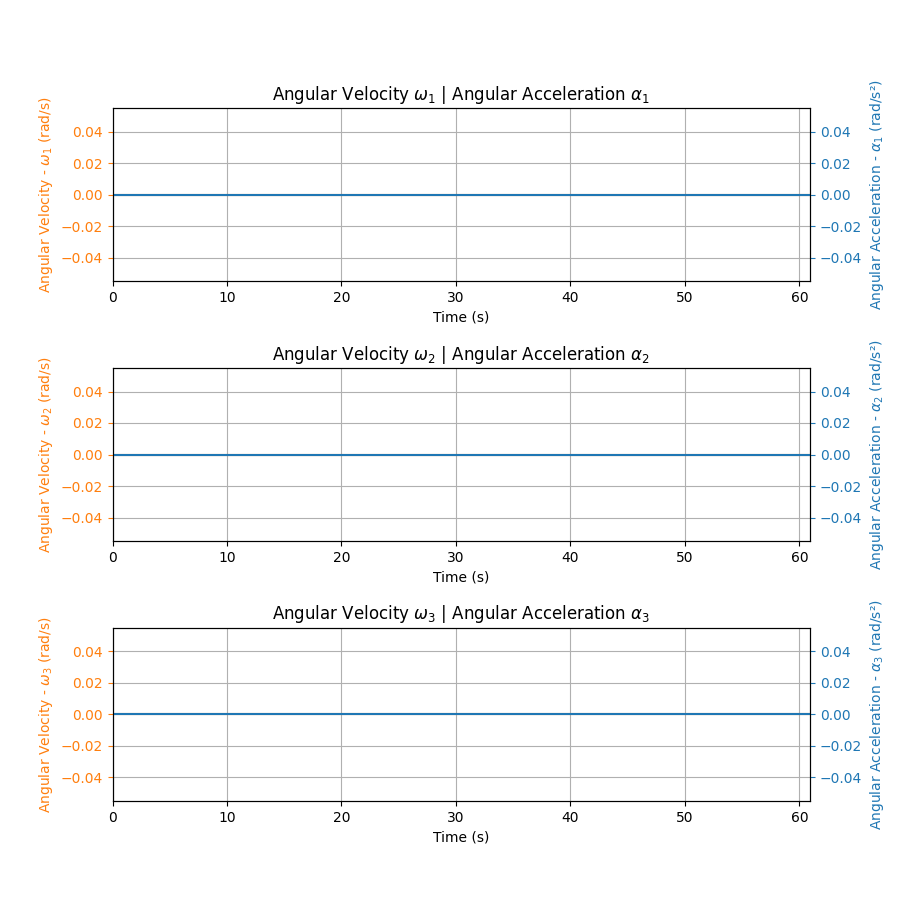



Trajectory Force Plots



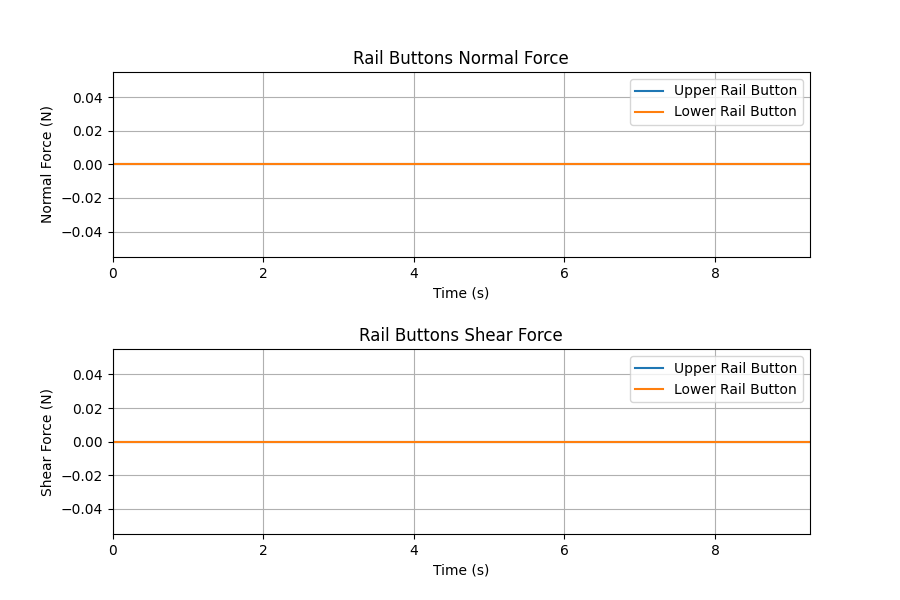

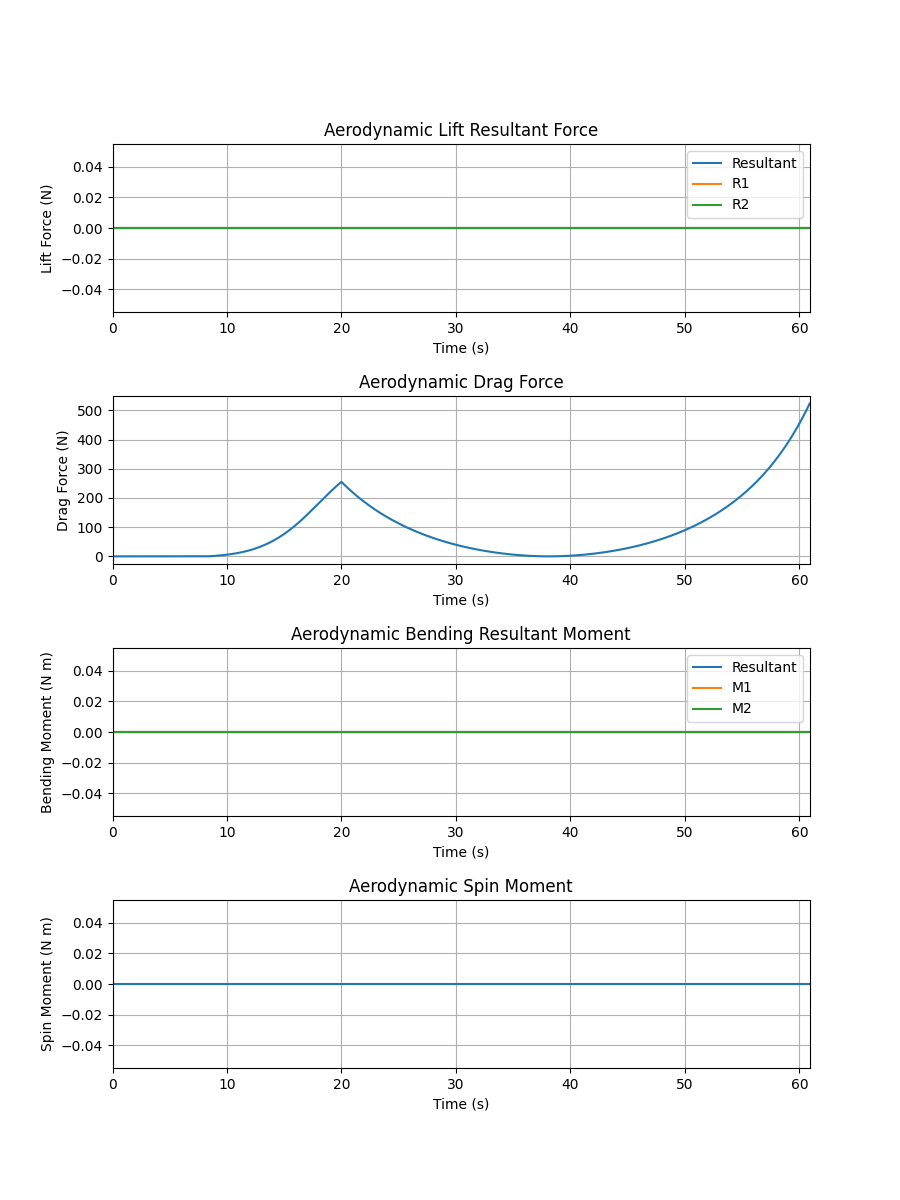



Trajectory Energy Plots



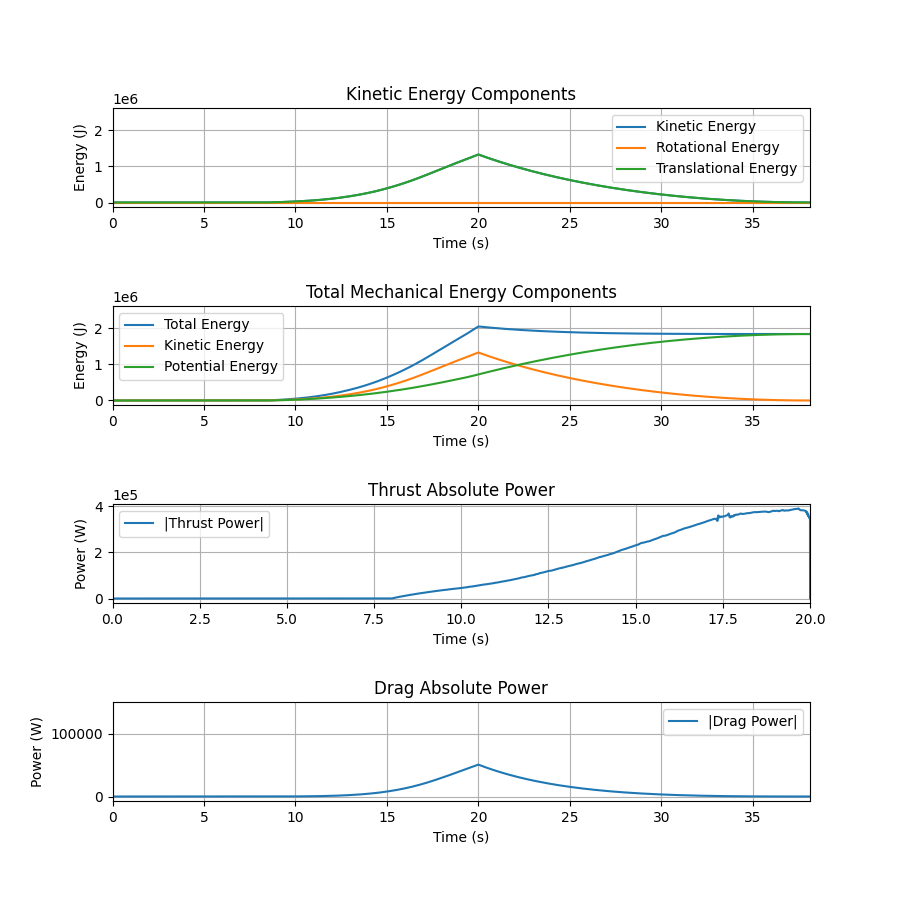



Trajectory Fluid Mechanics Plots



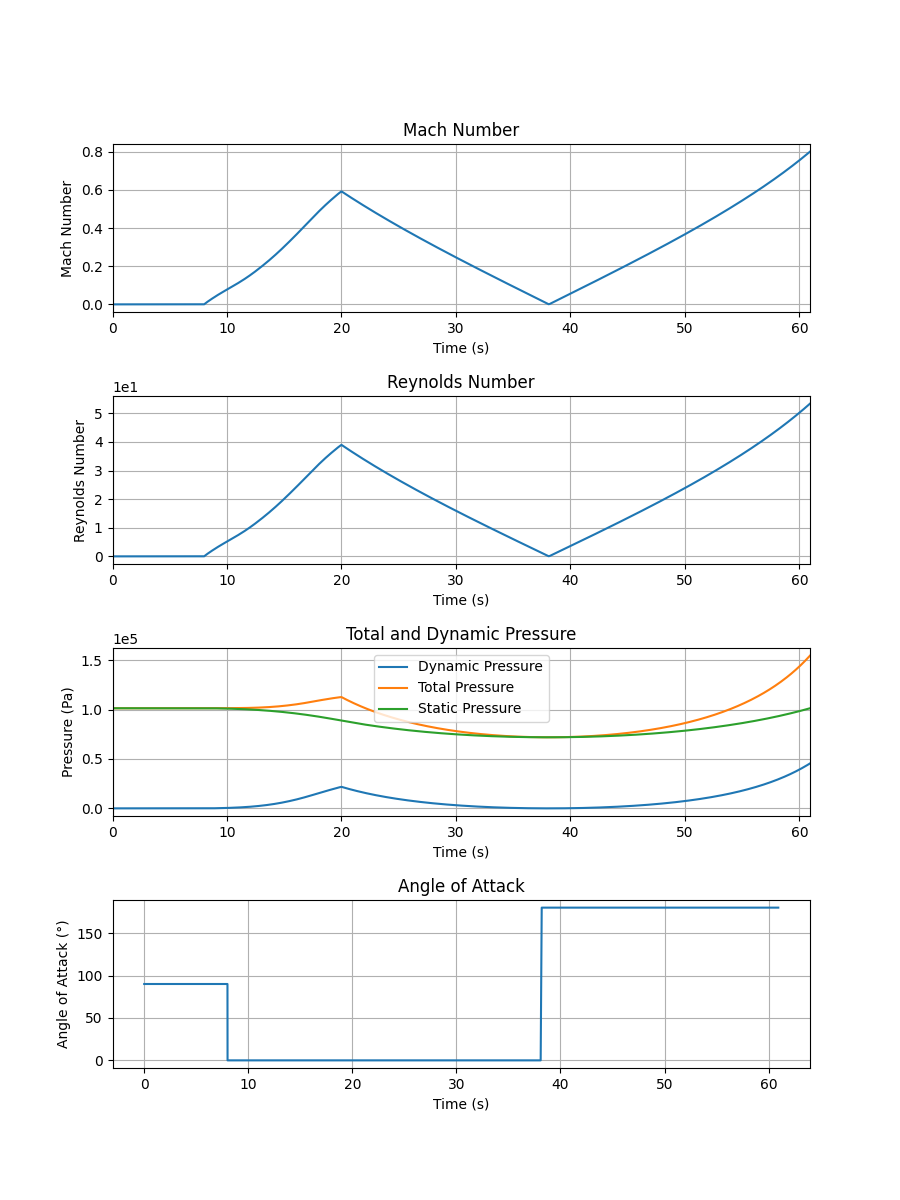



Trajectory Stability and Control Plots



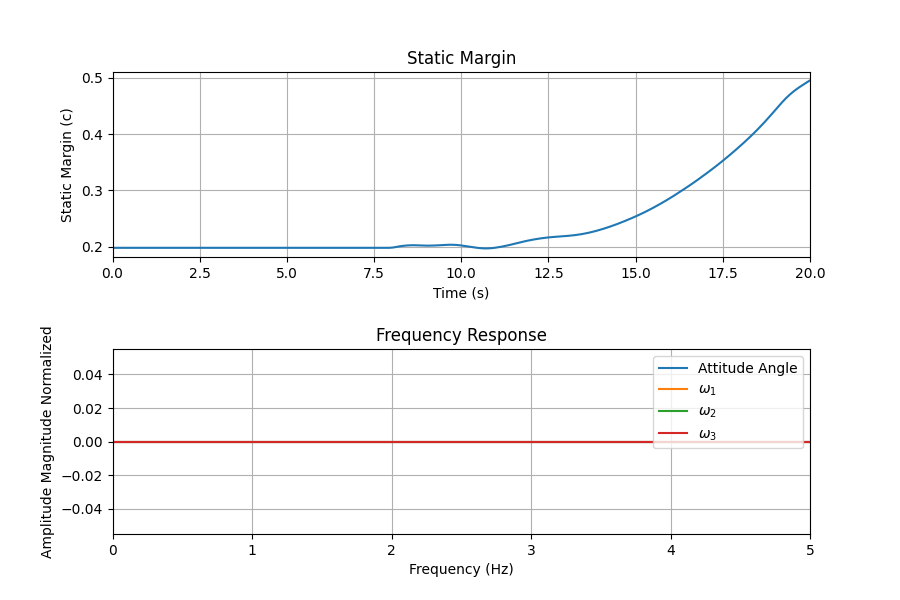

In [28]:
TestFlight.allInfo()

- Rocket radius (largest radius)
- Rocket dry mass (includes everything except propellant)
- Rocket inertia tensor (I, Z)
- Drag curves (power on, power off)
- Nozzle position 
- NoseCone length, kind (von Karman) and position (tip position)
- FinSet (n=3, rootChord, tipChord, span, position (tip of root chord), cantAngle)
- Boattail top radius, bottom radius, length, position (top radius position)